In [1]:
import os
import time
import math
import random
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
from functools import partial

# import tensorflow as tf
# import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# tf.test.is_gpu_available()

In [4]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [5]:
def compute_stats(values):
    mean = sum(values) / len(values)
    var_unb = sum((v - mean) ** 2 for v in values) / (len(values) -1)
    return mean, math.sqrt(var_unb)

In [27]:
NRUNS = 5

### F1 - simple gauss

In [28]:
import scipy.stats as spt

target = 1
target_precision = 1e-3

norm_dist = spt.norm(loc=0.5, scale=0.01)

prefix = 'f1'

target_dict = {
    'f1_d2': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 2,
    'f1_d4': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 4,
    'f1_d6': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 6,
    'f1_d8': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 8,
}
target_dict

{'f1_d2': 1.0, 'f1_d4': 1.0, 'f1_d6': 1.0, 'f1_d8': 1.0}

In [29]:
sigma = 0.01
alpha = sigma * np.sqrt(2)
pi = np.pi


def f1_np(x, ndims):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** ndims
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

def f1(x, ndims):
    pre = 1.0 / (alpha * math.sqrt(pi)) ** ndims
    exponent = -1 * sum((t - .5) ** 2 for t in x) / alpha ** 2
    return pre * math.exp(exponent)

In [30]:
dim2func_dict = {
    2: partial(f1, ndims=2),
    4: partial(f1, ndims=4),
    6: partial(f1, ndims=6),
    8: partial(f1, ndims=8),
}
dim2func_dict

{2: functools.partial(<function f1 at 0x000001EEB1DF8798>, ndims=2),
 4: functools.partial(<function f1 at 0x000001EEB1DF8798>, ndims=4),
 6: functools.partial(<function f1 at 0x000001EEB1DF8798>, ndims=6),
 8: functools.partial(<function f1 at 0x000001EEB1DF8798>, ndims=8)}

#### Uniform

In [31]:
# %%time
# np.random.set_seed(123)
random.seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2, 4, 6, 8]
neval_lst = list(map(int, [1e4, 1e5, 1e6, 1e7]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  neval={neval}')

            time_a = time.time()
            data = [[random.random() for _ in range(ndims)] for _ in range(neval)]
            gen_time = time.time() - time_a
            
            time_a = time.time()
            values = [integrand(p) for p in data]
            mean, std = compute_stats(values)
            error = std / math.sqrt(neval)
            eval_time = time.time() - time_a
            
            result_means.append(mean)
            result_sdevs.append(error)
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=10000000
ndims=8  neval=10000
ndims=8  neval=100000
ndims=8  neval=1000000
ndims=8  neval=10000000
run=2
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=10000000
ndims=8  neval=10000
ndims=8  neval=100000
ndims=8  neval=1000000
ndims=8  neval=10000000
run=3
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=1

In [32]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)
temp_df['total_time'] = temp_df.result_gen_time + temp_df.result_eval_time

In [33]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc,total_time
0,2,10000,5.964543e-01,1.737369e-01,1.355376,0.524597,1,0.28,1.879974
1,2,100000,9.190619e-01,8.587087e-02,0.059840,0.287232,1,0.83,0.347072
2,2,1000000,1.030651e+00,2.878654e-02,0.613360,2.860353,1,0.82,3.473713
3,2,10000000,9.979290e-01,8.900950e-03,8.615965,28.371149,1,0.77,36.987114
4,4,10000,7.010504e-06,7.010504e-06,0.665222,0.518614,1,0.44,1.183836
...,...,...,...,...,...,...,...,...,...
75,6,10000000,6.307629e-05,5.927791e-05,13.880889,35.015386,5,0.72,48.896275
76,8,10000,1.209372e-128,1.209372e-128,1.124993,0.527589,5,0.32,1.652582
77,8,100000,7.964959e-44,7.964959e-44,0.111701,0.381979,5,0.77,0.493680
78,8,1000000,3.245218e-52,3.245218e-52,1.300523,3.839734,5,0.75,5.140257


In [34]:
os.makedirs('result/02_NaivePython', exist_ok=True)
temp_df.to_csv('result/02_NaivePython/f1_uniform_new.csv', index=False)

In [6]:
# temp_df = pd.read_csv('result/02_NaivePython/f1_uniform_new.csv')

In [36]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'total_time',
                       'eval_time_perc']]

In [37]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,total_time,eval_time_perc
0,2,10000,9.568347e-01,2.675169e-01,1.303316,0.519810,1.823126,0.286
1,2,100000,9.531328e-01,8.679847e-02,0.059242,0.284838,0.344080,0.830
2,2,1000000,1.012006e+00,2.851523e-02,0.609570,2.846390,3.455960,0.820
3,2,10000000,1.001732e+00,8.927502e-03,8.415701,28.507983,36.923684,0.772
4,4,10000,5.249717e+00,5.248839e+00,0.642682,0.517017,1.159700,0.448
5,4,100000,3.175400e-01,3.149439e-01,0.076595,0.318349,0.394944,0.806
6,4,1000000,1.800478e+00,1.188313e+00,0.792481,3.202837,3.995318,0.800
7,4,10000000,1.145520e+00,3.033529e-01,10.557774,32.032760,42.590533,0.752
8,6,10000,1.729458e-19,1.729458e-19,0.800660,0.520608,1.321268,0.396
9,6,100000,7.149440e-21,7.142861e-21,0.096342,0.352657,0.448999,0.786


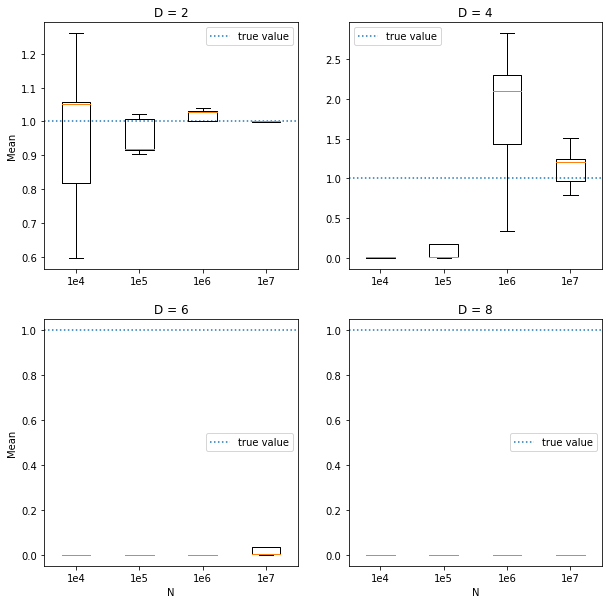

In [38]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(10,10))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(2,2,i+1)
    ax.axhline(y=target_dict[f'{prefix}_d{ndims}'], linestyle=':', label='true value')
    ax.set_title(f'D = {ndims}')
    if i > 1:
        ax.set_xlabel('N')
    if i % 2 == 0:
        ax.set_ylabel('Mean')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=False)
    ax.legend()

In [39]:
fig.savefig('result/02_NaivePython/f1_uniform_mean_new.png')

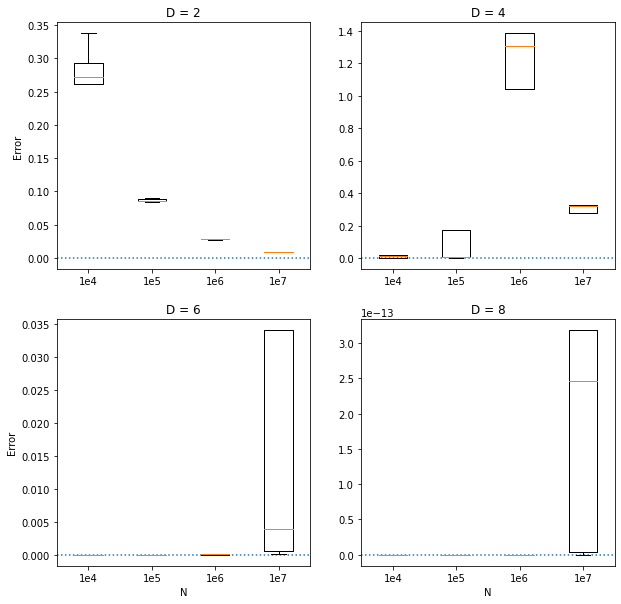

In [59]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(10,10))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(2,2,i+1)
    ax.axhline(y=0, linestyle=':')
    ax.set_title(f'D = {ndims}')
    if i > 1:
        ax.set_xlabel('N')
    if i % 2 == 0:
        ax.set_ylabel('Error')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=False)

In [60]:
fig.savefig('result/02_NaivePython/f1_uniform_error_new.png')

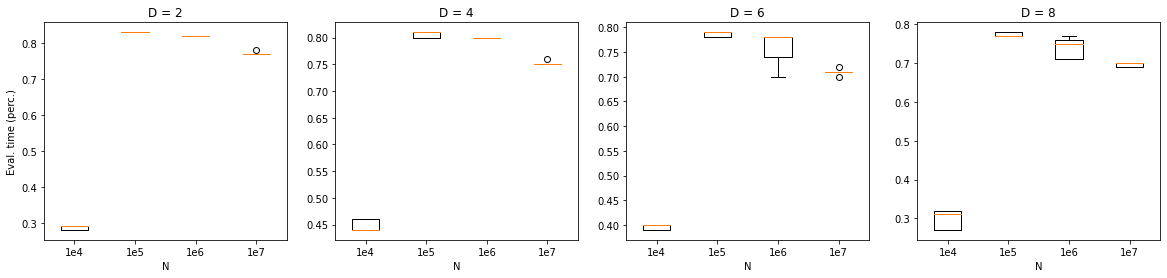

In [43]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Eval. time (perc.)')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

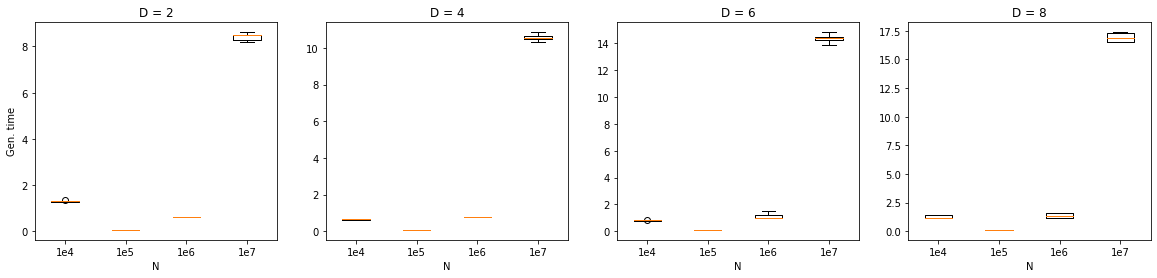

In [44]:
# result_gen_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_gen_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Gen. time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

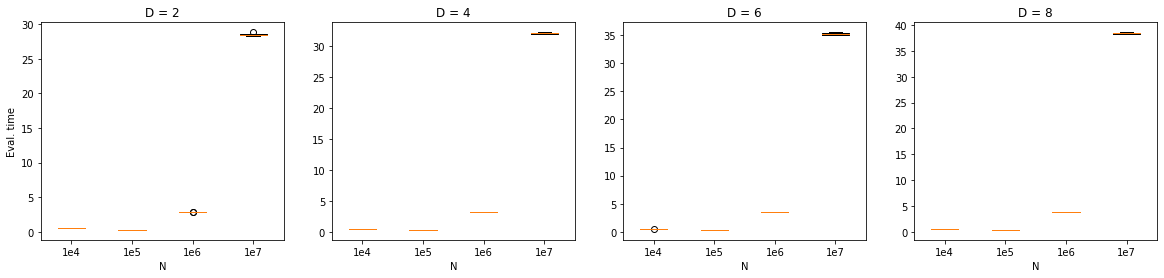

In [45]:
# result_eval_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_eval_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Eval. time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

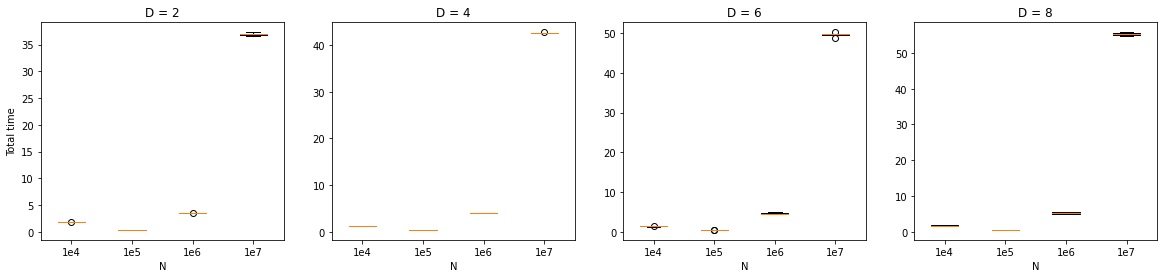

In [46]:
# total_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].copy()
    plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
    plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Total time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

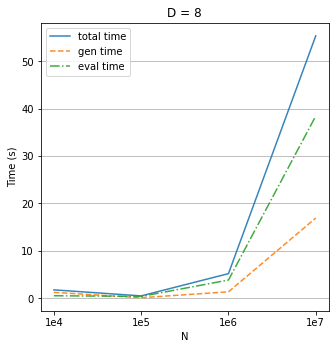

In [52]:
# total_time (D8) vs samples

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])

plot_data = g_temp_df[g_temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
ax.set_title(f'D = {ndims}')
ax.set_xlabel('N')
ax.set_ylabel('Time (s)')
# ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None);
locs = ax.get_xticks()
ax.set_xticks(ax.get_xticks(), labels=['', '1e4', '1e5', '1e6', '1e7', ''])
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='-', alpha=.9, label='total time')

plot_data = g_temp_df[g_temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['result_gen_time'].apply(lambda x: x.tolist())
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='dashed', alpha=.9, label='gen time')

plot_data = g_temp_df[g_temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['result_eval_time'].apply(lambda x: x.tolist())
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='dashdot', alpha=.9, label='eval time')

ax.legend()
ax.grid(axis='y')

In [53]:
fig.savefig('result/02_NaivePython/f1_uniform_time_new.png', bbox_inches='tight')

#### Time

In [7]:
time_df = temp_df[temp_df.neval == int(1e7)].groupby('ndims').agg([np.mean, np.std])

In [8]:
time_df

# result_sdev reaches {0.001757, 0.009955, 0.054550, 0.348377} on N = 1e7 samples

neval        result_mean                 result_sdev  \
             mean  std          mean           std          mean   
ndims                                                              
2      10000000.0  0.0  1.001732e+00  5.507613e-03  8.927502e-03   
4      10000000.0  0.0  1.145520e+00  2.767846e-01  3.033529e-01   
6      10000000.0  0.0  8.943712e-01  1.977858e+00  8.941895e-01   
8      10000000.0  0.0  3.711593e-13  5.315901e-13  3.711513e-13   

                    result_gen_time           result_eval_time            \
                std            mean       std             mean       std   
ndims                                                                      
2      2.026251e-05        8.415701  0.172457        28.507983  0.196947   
4      7.861155e-02       10.557774  0.205173        32.032760  0.125223   
6      1.977951e+00       14.373771  0.346665        35.223429  0.225723   
8      5.315970e-13       16.908395  0.428311        38.434644  0.110912   

      run_num           eval_time_perc           total_time            
         mean       std           mean       std       mean       std  
ndims                                                                  
2         3.0  1.581139          0.772  0.004472  36.923684  0.289341  
4         3.0  1.581139          0.752  0.004472  42.590533  0.097944  
6         3.0  1.581139          0.710  0.007071  49.597201  0.490693  
8         3.0  1.581139          0.696  0.005477  55.343039  0.386313

In [9]:
time_df[['result_gen_time', 'result_eval_time', 'total_time']]

result_gen_time           result_eval_time           total_time  \
                 mean       std             mean       std       mean   
ndims                                                                   
2            8.415701  0.172457        28.507983  0.196947  36.923684   
4           10.557774  0.205173        32.032760  0.125223  42.590533   
6           14.373771  0.346665        35.223429  0.225723  49.597201   
8           16.908395  0.428311        38.434644  0.110912  55.343039   

                 
            std  
ndims            
2      0.289341  
4      0.097944  
6      0.490693  
8      0.386313

In [57]:
def temp_print(xx):
    temp_foo = lambda x4: x4[0] + ' ± ' + x4[1] + '\t& ' + x4[2] + ' ± ' + x4[3] + '\n'
    print(''.join([temp_foo(x.round(5).astype(str))
           for x in xx.values]))
    
temp_print(time_df[['result_gen_time', 'result_eval_time']])

8.4157 ± 0.17246	& 28.50798 ± 0.19695
10.55777 ± 0.20517	& 32.03276 ± 0.12522
14.37377 ± 0.34666	& 35.22343 ± 0.22572
16.9084 ± 0.42831	& 38.43464 ± 0.11091



In [20]:
# old sigma

# def temp_print(xx):
#     temp_foo = lambda x4: x4[0] + ' ± ' + x4[1] + '\t& ' + x4[2] + ' ± ' + x4[3] + '\n'
#     print(''.join([temp_foo(x.round(3).astype(str))
#            for x in xx.values]))
    
# temp_print(time_df[['result_gen_time', 'result_eval_time']])

8.857 ± 0.295	& 28.169 ± 0.116
11.174 ± 0.163	& 31.525 ± 0.048
14.951 ± 0.395	& 34.955 ± 0.125
17.395 ± 0.524	& 38.048 ± 0.084



In [17]:
t = time_df[['result_gen_time', 'result_eval_time']]
t['total_mean'] = time_df['result_gen_time']['mean'] + time_df['result_eval_time']['mean']
t['total_std'] = (time_df['result_gen_time']['std']**2 + time_df['result_eval_time']['std']**2)**.5

t

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


result_gen_time           result_eval_time           total_mean  \
                 mean       std             mean       std              
ndims                                                                   
2            8.856975  0.294607        28.168985  0.115902  37.025960   
4           11.174443  0.163424        31.525340  0.047521  42.699784   
6           14.951008  0.395227        34.955499  0.124870  49.906506   
8           17.394804  0.524048        38.047893  0.084381  55.442698   

      total_std  
                 
ndims            
2      0.316586  
4      0.170193  
6      0.414484  
8      0.530798

In [22]:
def temp_print(xx):
    temp_foo = lambda x4: x4[0] + ' ± ' + x4[1] + '\n'
    print(''.join([temp_foo(x.round(3).astype(str))
           for x in xx.values]))
    
temp_print(t[['total_mean', 'total_std']])

37.026 ± 0.317
42.7 ± 0.17
49.907 ± 0.414
55.443 ± 0.531

